# Getting started with XGI

[XGI](https://xgi.readthedocs.io) is a Python library to make working with and analyzing complex systems with higher-order interactions easy. It contains useful functions, algorithms, and tools for working with hypergraphs and simplicial complexes to make life easier.

We will
1. Create and load hypergraphs
2. Convert to different hypergraph representations
2. Visualize hypergraphs and simplicial complexes
3. Show how to use the stats interface
4. Give an example of how to compare an empirical dataset to a null model.

We start off by loading the XGI library.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import xgi
from IPython.display import display
from matplotlib.pyplot import cm

In [2]:
xgi.__version__

'0.6'

### Creating a hypergraph

We want to start with a hypergraph, and this can be done in several ways:
1. Build a hypergraph node-by-node and edge-by-edge (less common, but can be helpful in writing your own generative models)
2. Load an existing dataset
3. Generate from an existing higher-order model

Let's start with the first method.

#### Building a hypergraph

In [3]:
H_build = xgi.Hypergraph()
H_build.add_edge([1, 2], id="a")
H_build.add_node(0)
H_build.add_edges_from([[3, 4], [0, 2, 3]])
H_build.add_nodes_from([9, 10])

XGI automatically assigns unique edge IDs (if a user doesn't specify the ID)

In [4]:
H_build.edges

EdgeView(('a', 0, 1))

Why NodeViews and EdgeViews? These allow users to access many different properties and data structures from nodes and edges in a much simpler way. We will cover this more in depth later. For now, we can get the edges of which each node is a part and the nodes in each edge as follows:

In [5]:
print(H_build.nodes.memberships())
print(H_build.edges.members())
print(H_build.nodes.memberships(2))
print(H_build.edges.members("a"))

{1: {'a'}, 2: {'a', 1}, 0: {1}, 3: {0, 1}, 4: {0}, 9: set(), 10: set()}
[{1, 2}, {3, 4}, {0, 2, 3}]
{'a', 1}
{1, 2}


#### Loading datasets

Moving on to method 2, one can load datasets in several different ways. First, we provide a companion data repository, [xgi-data](https://gitlab.com/complexgroupinteractions/xgi-data), where users can easily load several datasets in standard format:

In [6]:
H_enron = xgi.load_xgi_data("email-enron")
# H_enron = xgi.load_xgi_data("email-enron", read=True, path="../xgi-data/data/email-enron")

This dataset, for example, has a corresponding [datasheet](https://gitlab.com/complexgroupinteractions/xgi-data-email-enron/-/blob/main/README.md) explaining its characteristics. The nodes (individuals) in this dataset contain associated email addresses and the edges (emails) contain associated timestamps. These attributes can be accessed by simply typing `H.nodes[id]` or `H.edges[id]` respectively.

In [7]:
print(f"The hypergraph has {H_enron.num_nodes} nodes and {H_enron.num_edges} edges")

The hypergraph has 148 nodes and 10885 edges


In [8]:
print("The first 10 node IDs are:")
print(list(H_enron.nodes)[:10])
print("\nThe first 10 edge IDs are:")
print(list(H_enron.edges)[:10])
print("\nThe attributes of node '4' are")
print(H_enron.nodes["4"])
print("\nThe attributes of edge '6' are")
print(H_enron.edges["6"])

The first 10 node IDs are:
['4', '1', '117', '129', '51', '41', '65', '107', '122', '29']

The first 10 edge IDs are:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

The attributes of node '4' are
{'name': 'robert.badeer@enron.com'}

The attributes of edge '6' are
{'timestamp': '2000-02-22T08:07:00'}


We can clean up this dataset to remove isolates, multi-edges, singletons, and to replace all IDs with integer IDs.

In [9]:
H_enron_cleaned = H_enron.cleanup(in_place=False)

print(
    f"The hypergraph has {H_enron_cleaned.num_nodes} nodes and {H_enron_cleaned.num_edges} edges"
)

print("The first 10 node IDs are:")
print(list(H_enron_cleaned.nodes)[:10])

The hypergraph has 143 nodes and 1514 edges
The first 10 node IDs are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Likewise, one can load from a file. In the `readwrite` module, there are functions for handling a variety of file formats. We may also be interested in the *dual* hypergraph formed by considering nodes to be emails and edges to be email addresses:

#### Random null models

Lastly, we can create  synthetic hypergraphs using random generative models. For example, we can extract the degree and edge size sequence from this dataset and wire them together at random (according to the Chung-Lu model) to create a random null model:

In [10]:
D = H_enron_cleaned.dual()
k = D.degree()
s = D.size()

H_cl = xgi.chung_lu_hypergraph(k, s)

We check whether this new hypergraph is connected and if not, the sizes of the connected components:

In [11]:
connected = xgi.is_connected(H_cl)
if not connected:
    size, num = np.unique(
        [len(cc) for cc in xgi.connected_components(H_cl)], return_counts=True
    )
    print(f"The connected components:")
    display(pd.DataFrame([size, num], columns=["Component size", "Number"]))
else:
    print("The hypergraph is connected!")

The connected components:


,Component size,Number
0,1,1360
1,154,1


We can do much more such as computing different properties, reading/writing, converting to/from different data structures, hypergraph null models and much more!

See the Read The Docs for more information: https://xgi.readthedocs.io

### Converting between different representations

#### Incidence matrix

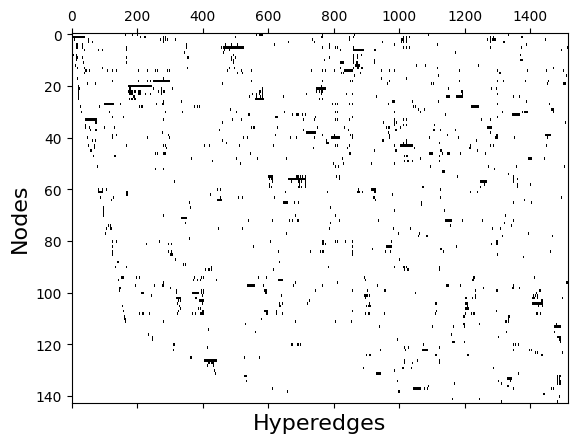

In [12]:
I = xgi.incidence_matrix(H_enron_cleaned, sparse=False)
plt.spy(I, aspect="auto")
plt.xlabel("Hyperedges", fontsize=16)
plt.ylabel("Nodes", fontsize=16)
plt.show()

#### Bipartite network

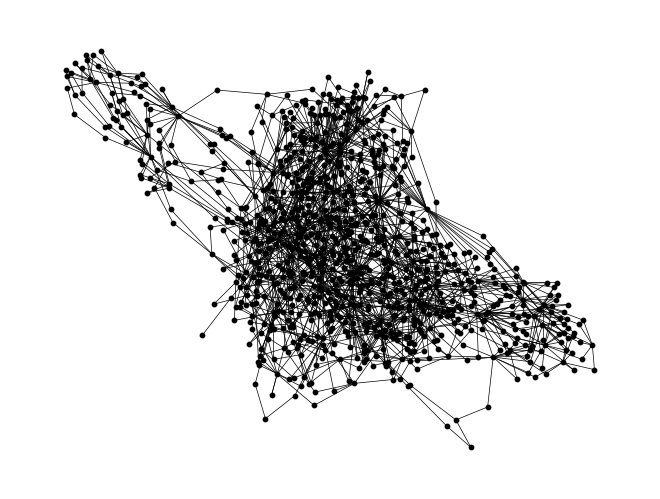

In [13]:
H_bi = xgi.load_xgi_data("email-enron", max_order=1)
H_bi.cleanup()
G = xgi.to_bipartite_graph(H_bi)
nx.draw(G, node_color="black", node_size=10, width=0.5)

#### Adjacency matrix

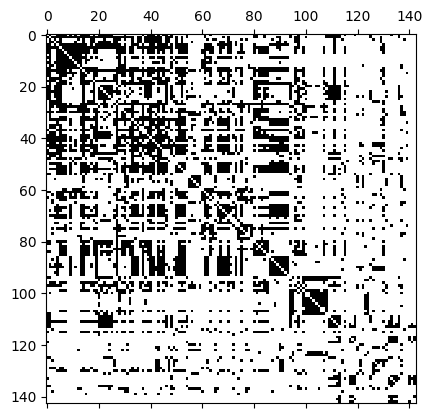

In [14]:
A = xgi.adjacency_matrix(H_enron_cleaned, sparse=False)
plt.spy(A)
plt.show()

#### Line graph

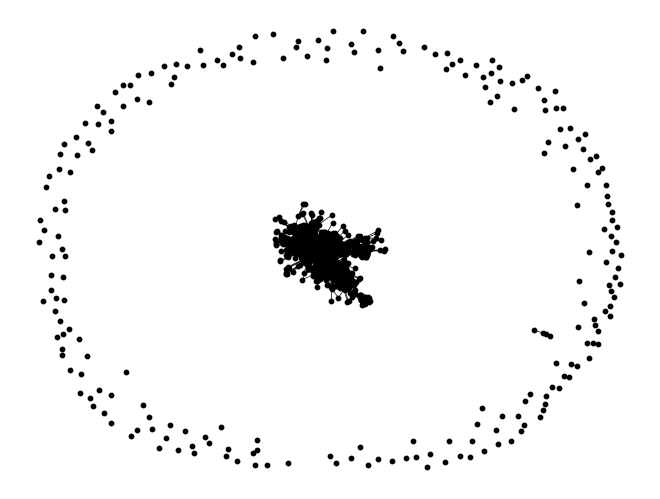

In [15]:
G = xgi.to_line_graph(H_enron_cleaned, s=2)
nx.draw(G, node_color="black", node_size=10, width=0.5)

#### The dual

In [16]:
D = H_enron_cleaned.dual()
print(f"The hypergraph has {D.num_nodes} nodes and {D.num_edges} edges")

The hypergraph has 1514 nodes and 143 edges


### Visualization

The first step for drawing a hypergraph is to choose a layout for the nodes. At the moment the available layouts are:
* `random_layout`: positions nodes uniformly at random in the unit square.
* `pairwise_spring_layout`: positions the nodes using the Fruchterman-Reingold force-directed algorithm on the projected graph.
* `barycenter_spring_layout` and `weighted_barycenter_spring_layout`: slight modification of `pairwise_spring_layout`
* `circular_layout` and `spiral_layout`
    
Each layout returns a dictionary that maps nodes ID into (x, y) coordinates.

In [17]:
seed = 0
H_viz = xgi.random_hypergraph(20, [0.08, 0.005, 0.0001], seed=seed)

pos1 = xgi.random_layout(H_viz)
pos2 = xgi.pairwise_spring_layout(H_viz)
pos3 = xgi.barycenter_spring_layout(H_viz)
pos4 = xgi.weighted_barycenter_spring_layout(H_viz)
pos5 = xgi.circular_layout(H_viz)
pos6 = xgi.spiral_layout(H_viz)

<Axes: >

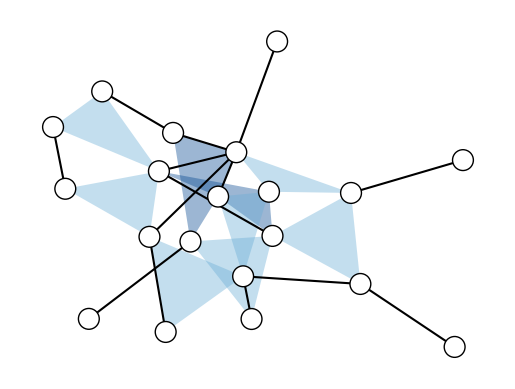

In [18]:
xgi.draw(H_viz, pos2)

Drawing parameters are extremely flexible:

<Axes: >

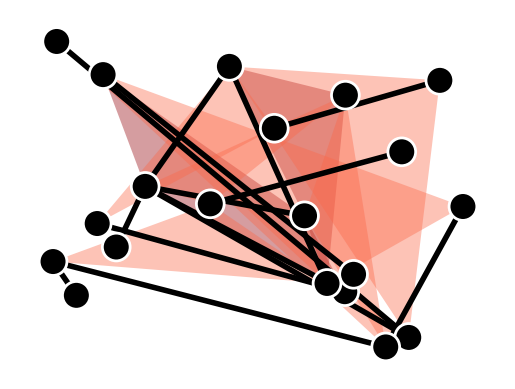

In [19]:
cmap = cm.Reds
dyad_lc = "gray"
dyad_lw = 4
node_fc = "black"
node_ec = "white"
node_lw = 2
node_size = 20

xgi.draw(
    H_viz,
    pos1,
    edge_fc_cmap=cmap,
    dyad_lc=dyad_lc,
    dyad_lw=dyad_lw,
    node_fc=node_fc,
    node_ec=node_ec,
    node_lw=node_lw,
    node_size=node_size,
)

We can even color/draw the nodes and edges based on statistics!

In [20]:
H = xgi.load_xgi_data("email-enron", max_order=2)
H.cleanup()
pos = xgi.pairwise_spring_layout(H)

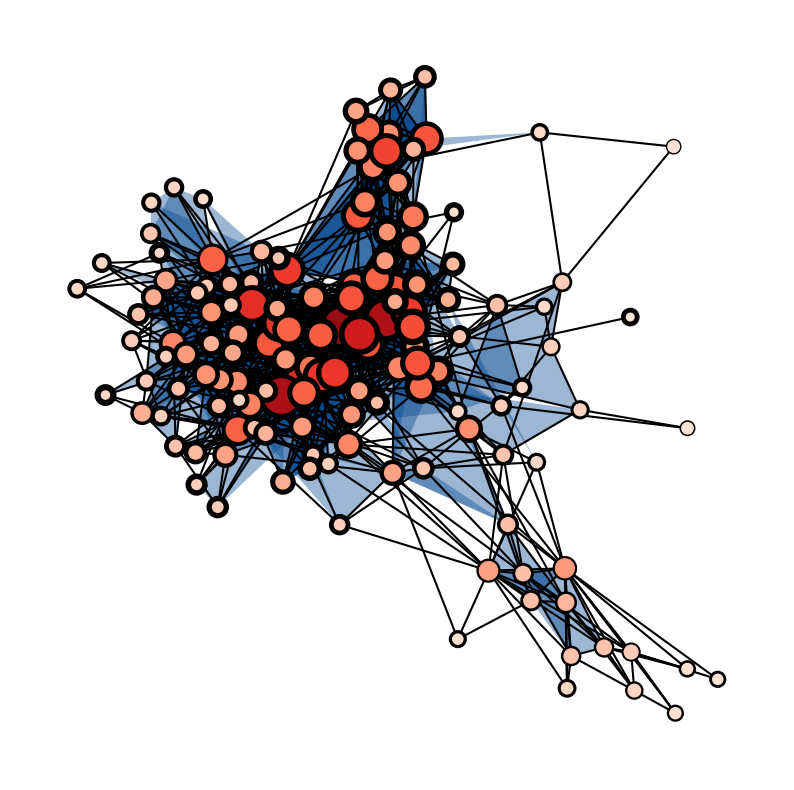

In [21]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
xgi.draw(
    H,
    pos,
    node_size=H.nodes.degree,
    node_lw=H.nodes.average_neighbor_degree,
    node_fc=H.nodes.degree,
    ax=ax,
)
plt.show()

PCA transform of the positions

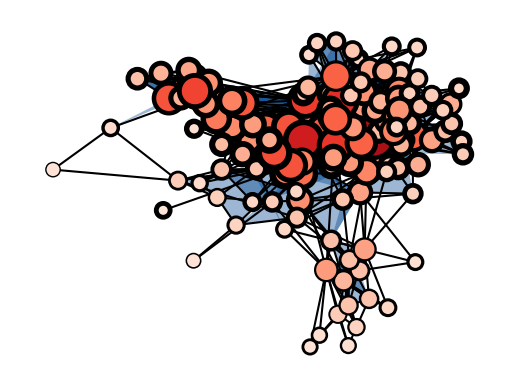

In [22]:
transformed_pos = xgi.pca_transform(pos, theta=90)
plt.figure()
ax = plt.subplot(111)
xgi.draw(
    H,
    transformed_pos,
    node_size=H.nodes.degree,
    node_lw=H.nodes.average_neighbor_degree,
    node_fc=H.nodes.degree,
    ax=ax,
)
plt.show()

### Visualizing simplicial complexes

Simplicial complexes can be visualized using the same functions for node layout and drawing.

### Technical note
By definition, a simplicial complex object contains all sub-simplices. This would make the visualization heavy since all sub-simplices contained in a maximal simplex would overlap. The automatic solution for this, implemented by default in all the layouts, is to convert the simplicial complex into a hypergraph composed solely of maximal simplices.

### Visual note
To visually distinguish simplicial complexes from hypergraphs, the ```draw``` function will also show all links contained in each maximal simplices (while omitting simplices of intermediate orders). 

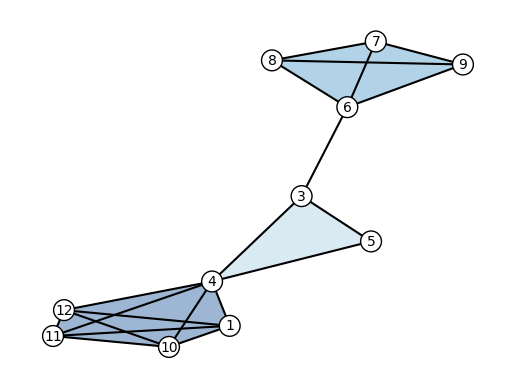

In [23]:
SC = xgi.SimplicialComplex()
SC.add_simplices_from([[3, 4, 5], [3, 6], [6, 7, 8, 9], [1, 4, 10, 11, 12], [1, 4]])

sc_pos = xgi.pairwise_spring_layout(SC)
xgi.draw(SC, sc_pos, node_labels=True)
plt.show()

## Statistics

Most of the functionality in the `Hypergraph` and `SimplicialComplex` classes takes care of modifying the unerlying structure of the network. Computing statistics, however, is done via the `stats` package, explored here.

The stats package is one of the features that sets `xgi` apart from other libraries. It provides a common interface to all statistics that can be computed from a network, its nodes, or edges.

### Introduction to Stat objects

Consider the degree of the nodes of a network `H`.  After computing the values of the
degrees, one may wish to store them in a dict, a list, an array, a dataframe, etc.
Through the stats package, `xgi` provides a simple interface that seamlessly allows for
this type conversion.  This is done via the `NodeStat` class.

In [24]:
import xgi

H = xgi.Hypergraph([[1, 2, 3], [2, 3, 4, 5], [3, 4, 5]])
H.nodes.degree

NodeStat('degree')

This `NodeStat` object is essentially a wrapper over a function that computes the
degrees of all nodes.  One of the main features of `NodeStat` objects is lazy
evaluation: `H.nodes.degree` will not compute the degrees of nodes until a specific
output format is requested.

In [25]:
H.nodes.degree.asdict()

{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

In [26]:
H.nodes.degree.aslist()

[1, 2, 3, 2, 2]

In [27]:
H.nodes.degree.asnumpy()

array([1, 2, 3, 2, 2])

To compute the degrees of a subset of the nodes, call `degree` from a smaller `NodeView`.

In [28]:
H.nodes([3, 4, 5]).degree.asdict()

{3: 3, 4: 2, 5: 2}

Alternatively, to compute the degree of a single node, use square brackets.

In [29]:
H.nodes.degree[4]

2

Make sure the accessed node is in the underlying view.

In [30]:
# This will raise an exception
# because node 4 is not in the view [1, 2, 3]
#
# H.nodes([1, 2, 3]).degree[4]
#

args and kwargs may be passed to `NodeStat` objects, which will be stored and used when
the evaluation finally takes place.  For example, use the `order` keyword of `degree` to
count only those edges of the specified order.

In [31]:
H.nodes.degree(order=3)

NodeStat('degree', kwargs={'order': 3})

In [32]:
H.nodes.degree(order=3).aslist()

[0, 1, 1, 1, 1]

The stats package provides some convenience functions for numerical operations.

In [33]:
import numpy as np

st = H.nodes.degree
np.round([st.max(), st.min(), st.mean(), st.median(), st.var(), st.std()], 3)

array([3.   , 1.   , 2.   , 2.   , 0.4  , 0.632])

As a convenience, each node statistic may also be accessed directly through the network itself.

In [34]:
H.degree()

{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

Note however that `H.degree` is a method that simply returns a dict, not a `NodeStat` object and thus does not support the features discussed above.

## Node attributes

Node attributes can be conceived of as a node-object mapping and thus they can also be accessed using the `NodeStat` interface and all its funcitonality.

In [35]:
H.add_nodes_from(
    [
        (1, {"color": "red", "name": "horse"}),
        (2, {"color": "blue", "name": "pony"}),
        (3, {"color": "yellow", "name": "zebra"}),
        (4, {"color": "red", "name": "orangutan", "age": 20}),
        (5, {"color": "blue", "name": "fish", "age": 2}),
    ]
)

Access all attributes of all nodes by specifying a return type.

In [36]:
H.nodes.attrs.asdict()

{1: {'color': 'red', 'name': 'horse'},
 2: {'color': 'blue', 'name': 'pony'},
 3: {'color': 'yellow', 'name': 'zebra'},
 4: {'color': 'red', 'name': 'orangutan', 'age': 20},
 5: {'color': 'blue', 'name': 'fish', 'age': 2}}

Access all attributes of a single node by using square brackets.

In [37]:
H.nodes.attrs[1]

{'color': 'red', 'name': 'horse'}

Access a single attribute of all nodes by specifying a return type.

In [38]:
H.nodes.attrs("color").aslist()

['red', 'blue', 'yellow', 'red', 'blue']

If a node does not have the specified attribute, `None` will be used.

In [39]:
H.nodes.attrs("age").asdict()

{1: None, 2: None, 3: None, 4: 20, 5: 2}

Use the `missing` keyword argument to change the imputed value.

In [40]:
H.nodes.attrs("age", missing=100).asdict()

{1: 100, 2: 100, 3: 100, 4: 20, 5: 2}

## Filtering

`NodeView` objects are aware of existing `NodeStat` objects via the `filterby` method.

In [41]:
H.degree()

{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

In [42]:
H.nodes.filterby("degree", 2)  # apply the filter to all nodes

NodeView((2, 4, 5))

In [43]:
H.nodes.filterby("degree", [3, 4], mode="between")

NodeView((3,))

Nodes can be filtered by attribute via the `filterby_attr` method.

In [44]:
H.nodes.filterby_attr("color", "red")

NodeView((1, 4))

Since `filterby*` methods return a `NodeView` object, multiple filters can be chained, as well as other `NodeStat` calls. The following call computes the local clustering coefficient of those nodes with degree equal to 2 and "color" attribute equal to "blue", and outputs the result as a dict.

In [45]:
(
    H.nodes.filterby("degree", 2)
    .filterby_attr("color", "blue")
    .clustering_coefficient.asdict()
)

{2: 0.6666666666666666, 5: 1.0}

For example, here is how to access the nodes with maximum degree.

In [46]:
H.nodes.filterby("degree", H.nodes.degree.max())

NodeView((3,))

## Multiple statistics

One can obtain multiple node statistics at the same time via the `multi` method, which returns `MultiNodeStat` objects.

In [47]:
H.nodes.multi(["degree", "clustering_coefficient"])

MultiNodeStat(degree, clustering_coefficient)

Objects of class `MultiNodeStat` also support lazy evaluation and type conversion.

In [48]:
H.nodes.multi(["degree", "clustering_coefficient"]).asdict()

{1: {'degree': 1, 'clustering_coefficient': 1.0},
 2: {'degree': 2, 'clustering_coefficient': 0.6666666666666666},
 3: {'degree': 3, 'clustering_coefficient': 0.6666666666666666},
 4: {'degree': 2, 'clustering_coefficient': 1.0},
 5: {'degree': 2, 'clustering_coefficient': 1.0}}

There are more options for the output type of a `MultiNodeStat` object.

In [49]:
ms = H.nodes.multi(["degree", "clustering_coefficient"])

from pprint import pprint

print("# dict of dicts, nodes first:")
pprint(ms.asdict())
print()
print("# dict of dicts, stats first:")
pprint(ms.asdict(transpose=True))
print()
print("# dict of lists:")
pprint(ms.asdict(list))
print()
print("# list of lists, nodes first:")
pprint(ms.aslist())
print()
print("# list of lists, stats first:")
pprint(ms.aslist(transpose=True))
print()
print("# list of dicts:")
pprint(ms.aslist(dict))

# dict of dicts, nodes first:
{1: {'clustering_coefficient': 1.0, 'degree': 1},
 2: {'clustering_coefficient': 0.6666666666666666, 'degree': 2},
 3: {'clustering_coefficient': 0.6666666666666666, 'degree': 3},
 4: {'clustering_coefficient': 1.0, 'degree': 2},
 5: {'clustering_coefficient': 1.0, 'degree': 2}}

# dict of dicts, stats first:
{'clustering_coefficient': {1: 1.0,
                            2: 0.6666666666666666,
                            3: 0.6666666666666666,
                            4: 1.0,
                            5: 1.0},
 'degree': {1: 1, 2: 2, 3: 3, 4: 2, 5: 2}}

# dict of lists:
{1: [1, 1.0],
 2: [2, 0.6666666666666666],
 3: [3, 0.6666666666666666],
 4: [2, 1.0],
 5: [2, 1.0]}

# list of lists, nodes first:
[[1, 1.0], [2, 0.6666666666666666], [3, 0.6666666666666666], [2, 1.0], [2, 1.0]]

# list of lists, stats first:
[[1, 2, 3, 2, 2], [1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0]]

# list of dicts:
[{'clustering_coefficient': 1.0, 'degree': 1},
 {'c

## Multiple statistics: dataframes

`MultiNodeStat` objects can immediately be output as a Pandas dataframe.

In [50]:
df = H.nodes.multi(["degree", "clustering_coefficient"]).aspandas()
df

,degree,clustering_coefficient
1,1,1.000000
2,2,0.666667
3,3,0.666667
4,2,1.000000
5,2,1.000000


For example, it is now easy to get the per-degree average local clustering coefficient.

In [51]:
df.groupby("degree").agg("mean")

,clustering_coefficient
degree,
1,1.000000
2,0.888889
3,0.666667


One may also immediately plot any statistics.

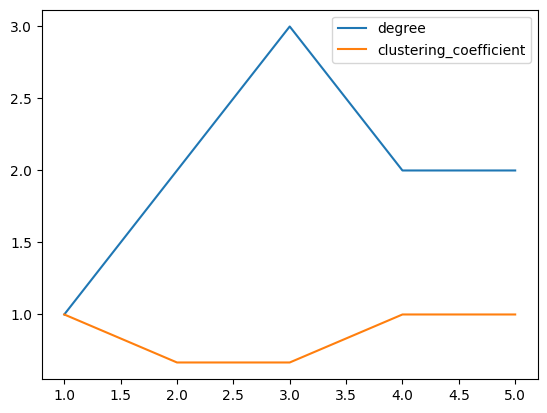

In [52]:
H.nodes.multi(["degree", "clustering_coefficient"]).aspandas().plot();

The `multi` method also accepts `NodeStat` objects, useful when passing arguments to each `NodeStat`, or when requesting attributes.

In [53]:
H.nodes.multi(["degree", H.nodes.degree(order=3), H.nodes.attrs("color")]).aspandas()

,degree,degree(order=3),attrs(color)
1,1,0,red
2,2,1,blue
3,3,1,yellow
4,2,1,red
5,2,1,blue


## Edge statistics

Every feature showcased above (lazy evaluation, type conversion, filtering, set operations, and multi objects) is supported for edge-quantity or edge-attribute mappings, via `EdgeStat` objects.

In [54]:
H.edges.order

EdgeStat('order')

In [55]:
H.edges.order.asdict()

{0: 2, 1: 3, 2: 2}

In [56]:
H.edges.filterby("order", 3)

EdgeView((1,))

In [57]:
H.edges.multi(["order", "size"]).aspandas()

,order,size
0,2,3
1,3,4
2,2,3


## User-defined statistics

Suppose during the course of your research you come up with a new node-level statistic. For the purpose of this tutorial, we are going to define a statistic called `user_degree`. The `user_degree` of a node is simply its standard degree times 10.

Since this is also a node-quantity mapping, we would like to give it the same interface as `degree` and all the other `NodeStat`s. The stats package provides a simple way to do this. Simply use the `nodestat_func` decorator.

In [58]:
@xgi.nodestat_func
def user_degree(net, bunch):
    """The user degree of a bunch of nodes in net."""
    return {n: 10 * net.degree(n) for n in bunch}

Now `user_degree` is a valid stat that can be computed on any hypergraph:

In [59]:
H.nodes.user_degree.asdict()

{1: 10, 2: 20, 3: 30, 4: 20, 5: 20}

Every single feature showcased above is available for use with `user_degree`, including filtering nodes and multi stats objects.

In [60]:
H.nodes.filterby("user_degree", 20)

NodeView((2, 4, 5))

In [61]:
H.nodes.multi(["degree", "user_degree"]).aspandas()

,degree,user_degree
1,1,10
2,2,20
3,3,30
4,2,20
5,2,20


The `@xgi.nodestat_func` decorator works on any function or callable that admits two parameters: `net` and `bunch`, where `net` is the network and `bunch` is an iterable of nodes in `net`. Additionally, the function must return a dictionary with pairs of the form `node: value`, where `node` is an element of `bunch`. The library will take care of type conversions, but the output value of this function must always be a dict.

User-defined edge statistics can similarly be defined using the `@xgi.edgestat_func` decorator.

## An example

Let's compare the assortativity of an empirical dataset (Let's choose the `email-enron` dataset) to a random null model. We start by loading the Enron dataset and constructing a Chung-Lu hypergraph using the dataset's degree sequence and edge size sequence:

In [62]:
H = H_enron
k = H.nodes.degree.asdict()
s = H.edges.size.asdict()

H_null = xgi.chung_lu_hypergraph(k, s)

Now we use the definitions of assortativity in "Configuration models of random hypergraphs" by Phil Chodrow to compare the assortativity of the random null model to the original dataset.

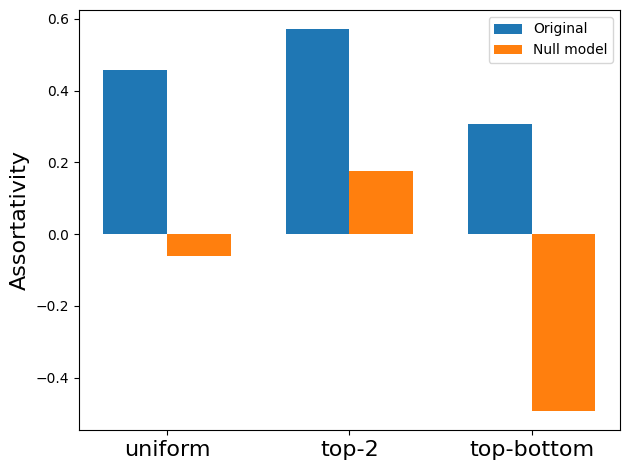

In [63]:
labels = ["uniform", "top-2", "top-bottom"]

assort_orig = []
assort_null = []
for l in labels:
    assort_orig.append(xgi.degree_assortativity(H, kind=l))
    assort_null.append(xgi.degree_assortativity(H_null, kind=l))

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, assort_orig, width, label="Original")
rects2 = ax.bar(x + width / 2, assort_null, width, label="Null model")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.set_ylabel("Assortativity", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

From this plot we can see that the original dataset is more assortative than the random null model.